In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#Building vocabulary of words and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#Building the dataset
block_size = 8 #Context length to specify how many characters we consider to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #sliding window
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #90%
Xte, Yte = build_dataset(words[n2:]) #10%

print(Xtr[:5])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 25],
        [ 0,  0,  0,  0,  0,  0, 25, 21],
        [ 0,  0,  0,  0,  0, 25, 21,  8],
        [ 0,  0,  0,  0, 25, 21,  8,  5]])


In [6]:
for x,y in zip(Xtr[:15], Ytr[:15]):
    print(''.join(itos[ix.item()] for ix in x), '---->', itos[y.item()])

........ ----> y
.......y ----> u
......yu ----> h
.....yuh ----> e
....yuhe ----> n
...yuhen ----> g
..yuheng ----> .
........ ----> d
.......d ----> i
......di ----> o
.....dio ----> n
....dion ----> d
...diond ----> r
..diondr ----> e
.diondre ----> .


In [7]:
#Building a deeper network and pytorchifying code

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    #forward pass
    def __call__(self, x): #x is input tensor
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        #buffers(trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x): #x is input tensor which is a batch.
        #forward pass
        if self.training:
            if x.ndim == 2:
                dim=0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out


    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


class Embeddings:
    
    def __init__(self, num_embeddings, emb_dims):
        self.weight = torch.randn((num_embeddings, emb_dims))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive: # Concatenating to follow the wavenet architecture

    def __init__(self, n):
        self.n = n # How many consecutive embs I want to concatenate
    
    def __call__(self, x):
        
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1]==1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42);

In [9]:

n_emb = 24 #Embedding dimension
n_hidden = 128 #No. of neurons in the hidden layer

#C = torch.randn((vocab_size, n_emb))

model = Sequential([
    Embeddings(vocab_size, n_emb), 
    FlattenConsecutive(2), Linear(   n_emb*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#Implemented the wavenet above.
#It merges 2 characters at a time considering a context length of 8 characters.
#Continues to merge across 3 layers


with torch.no_grad():
    #make last layer less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)



for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

76579
Embeddings : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [11]:
#optimization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for layer in model.layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update weights
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    #tracking stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:4d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/200000 : 3.1594
  10000/200000 : 1.9795
  20000/200000 : 1.7598
  30000/200000 : 2.1983
  40000/200000 : 2.4036
  50000/200000 : 1.5357
  60000/200000 : 2.1421
  70000/200000 : 1.8554
  80000/200000 : 1.6047
  90000/200000 : 1.9173
 100000/200000 : 1.9383
 110000/200000 : 1.8230
 120000/200000 : 1.8874
 130000/200000 : 1.8354
 140000/200000 : 2.2075
 150000/200000 : 1.7851
 160000/200000 : 2.1550
 170000/200000 : 1.8080
 180000/200000 : 1.7263
 190000/200000 : 1.6256


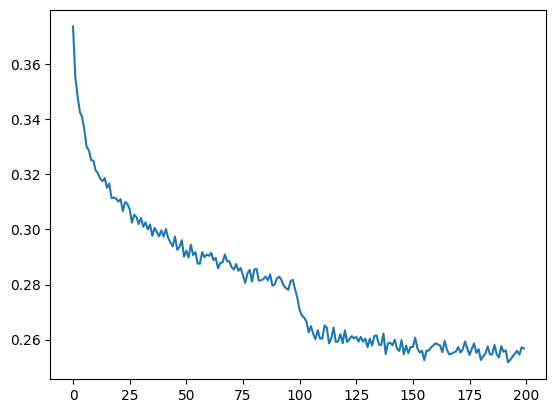

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [13]:
#put layers into eval mode (needed for batchnorm specifically)

for layer in model.layers:
    layer.training = False 

In [16]:
#Sampling from model


for i in range(10):
    
    ix = 0
    
    context = [0] * block_size 
    out = []
    
    while True:
        #do a forward pass and get the final distribution then sample from it to get next character and keep sampling until I run into a '.'
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        out.append(itos[ix])
        context = context[1:] + [ix]
    
        if ix==0:
            break
    
    
    print(''.join(j for j in out))
        

brianno.
desari.
moham.
swayd.
diaor.
dazion.
amyro.
yassyn.
chainieb.
sajavia.


In [ ]:
# Names look great yayyy 
# Things I am now more open to 
# Underrstanding residual and skip connections.
# Understanding conv layers and how they are implemented.
# Onto the transformer to see if I can beat these results and make the names qualitatively better!